# EE4375-2022: Second Lab Session: Finite Difference Method for the Poisson Equation on the Unit Interval

Solves the Poisson equation $- \frac{d^2 \, u(x)}{dx^2} = f(x)$ on the unit bar domain $x \in \Omega=(0,1)$ supplied with various boundary conditions and various source terms. The Galerkin finite element method is employed. This lab session complements the lectures with slides available at [shared drive](https://mega.nz/fm/CcsEnLxL). 

## Import All Required Packages

In [1]:
using LinearAlgebra
using SparseArrays
using Plots
using LaTeXStrings
using BenchmarkTools 

## Section 1/6: (Compulsory): One-Dimensional Finite Difference Code

### First Example: Analytically Specified Source Function $f(x)$

This first example uses the homogeneous Dirichlet boundary condition $u(x=0) = 0$ in the left end-point and the non-homogeneous Neumann boundary condition $\frac{d\,u}{dx}(x=1) = \alpha$ in the right end-point. The source function $f(x)$ is chosen as $f(x) = 1$ to mimmic the example in the slides. 

Exercise: Run the code below for various values of $\alpha$ and compare with the solutions given in the slides. What do you observe for positive and negative values of $\alpha$ with the same sign.  

In [65]:
#..construct the 1D mesh
N = 3; Np1 = N+1; h = 1/N; h2=h*h; 
x = Vector(0:h:1); 

#..construct the source function 
f = ones(size(x)); 
alpha = 3;
if false 
  plot(x,f)
end 

#..construct the coefficient matrix with our the boundary conditions 
e = ones(Np1); #..note that ones(N+1,1) does *not* work here 
A = Tridiagonal(-e[2:end], 2*e, -e[2:end]); 
A = (1/h2)*A; 

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,1] = 1;          A[1,2] = 0;          f[1] = 0; 
A[end,end-1]=-1/h;   A[end,end] = 1/h;    f[end] = alpha;  
    
#..solve the linear system
u = A \ f; 

#..plot the solution  
p1=plot(x,u,shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("u(x)")
title!("Numerically computed solution")
print(A)

[1.0 0.0 0.0 0.0; -9.0 18.0 -9.0 0.0; 0.0 -9.0 18.0 -9.0; 0.0 0.0 -3.0 3.0]

### Second Example: Analytically Specified Source f(x) Modeling a Pulse, Point Charge or a Single Wire 

This first examples uses the homogeneous Dirichlet boundary condition in both the left end-point and the right end-point. The source function $f(x)$ is chosen as a Gaussian pulse.

Exercise: change location and width of the pulse. Extend to more pulses with various, possibly negative, amplitudes. 

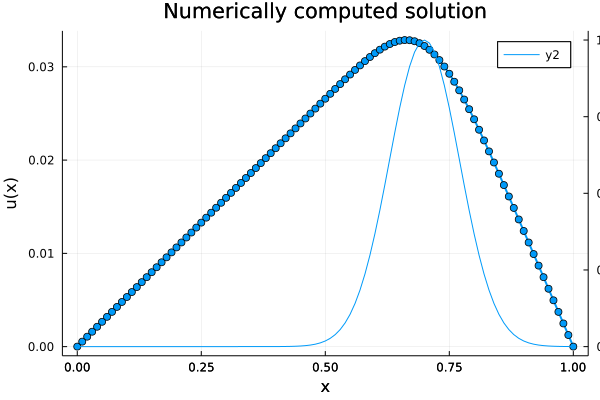

In [43]:
#..construct the 1D mesh
N = 100; Np1 = N+1; h = 1/N; h2=h*h; 
x = Vector(0:h:1); 

#..construct the source function 
#..x0 is scalar. Observe the use of pointwise operations (broadcast in Julia)
x0 = .7; f = exp.( - (x.-x0).^2 ./0.01 ); 
if false 
  plot(x,f)
end 

#..construct the coefficient matrix with our the boundary conditions 
e = ones(Np1); #..note that ones(N+1,1) does *not* work here 
A = Tridiagonal(-e[2:end], 2*e, -e[2:end]); 
A = (1/h2)*A; 

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,1] = 1;          A[1,2] = 0;          f[1] = 0; 
A[end,end-1]=0;      A[end,end] = 1;      f[end] = 0;  
    
#..solve the linear system
u = A \ f; 

#..plot the solution  
p1=plot(x,u,shape=:circle,lw=2)
p1=plot!(twinx(),x,f)
xlabel!("x") 
ylabel!("u(x)")
title!("Numerically computed solution")

Exercise: change location and width of the pulse. Extend to more pulses with various, possibly negative, amplitudes.

### Third Example: Add Post-Processing to compute the first and second order derivatives ux and uxx  

In this third examples we add functionality to be able to compute the first order derivative $u_x$ and the second order derivastive $u_{xx}$ in the post-processing stage of the simulations. The computation of $u_x$ will serve to compute the flux in later computation. It also serve as an intermediate step in solving a more complex variant of the same problem. The computation of $u_{xx}$ will serve to illustration certain feature of the finite difference method. We compute $u_x$ in the cell-centers. This implies that the size of the computed vector $u_x$ is one less than the size of the vector $u$. We compute $u_{xx}$ in the nodes. The computation of $u_{xx}$ in post-processing stage allows to verify that $u_{xx} = f(x)$, as required by the differential equation that we are trying to solve.  

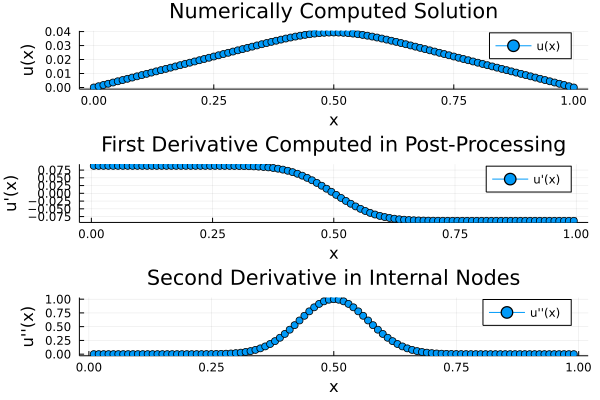

In [47]:
#..construct the 1D mesh
N = 100; Np1 = N+1; h = 1/N; h2=h*h; 
x = Vector(0:h:1); 
xmid = x[1:end-1].+h/2; 

#..construct the source function 
#..x0 is scalar. Observe the use of pointwise operations (broadcast in Julia)
x0 = .5; f = exp.( - (x.-x0).^2 ./0.01 ); 
if false 
  plot(x,f)
end 

#..construct the coefficient matrix with our the boundary conditions 
e = ones(Np1); #..note that ones(N+1,1) does *not* work here 
A = Tridiagonal(-e[2:end], 2*e, -e[2:end]); 
A = (1/h2)*A; 

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,1] = 1;          A[1,2] = 0;          f[1] = 0; 
A[end,end-1]=0;      A[end,end] = 1;      f[end] = 0;  

#..construct the matrix enabling the computation of ux and uxx 
#..we use comprehension to construct the rectangular matrix B 
B = [i==j ? -1/h : i==j-1 ? 1/h : 0 for i = 1:N, j=1:Np1]
BT = Transpose(B)

#..solve the linear system
u = A \ f; 

#..compute ux and uxx in the post-processing stage 
ux = B*u; 
uxx = BT*ux; 

#..plot the solution  
p1=plot(x,u,shape=:circle,lw=2, label="u(x)")
xlabel!("x") 
ylabel!("u(x)")
title!("Numerically Computed Solution")

#..plot the first derivative ux of the computed solution  
p2 = plot(xmid, ux, shape=:circle, lw=2, label="u'(x)")
xlabel!("x") 
ylabel!("u'(x)")
title!("First Derivative Computed in Post-Processing")

#..plot the second derivative uxx of the computed solution
p3 = plot(x[2:end-1], uxx[2:end-1], shape=:circle, lw=2, label="u''(x)")
xlabel!("x") 
ylabel!("u''(x)")
title!("Second Derivative in Internal Nodes")


plot(p1,p2,p3,layout=(3,1))
#C = BT*B 

## Section 2/6: (more details on the mathematics): Convergence Towards the Exact Solution 

### First Study: Converge of the Numerical Solution to the Exact Solution as the Mesh is Refined  

Assume the analytical (exact) solution to be known (either computed analytically (using pen and paper) or symbolically (using the dsolve() function within the Python package sympy.py as shown in a seperate notebook). Compute numerical solution of a sequence of finer meshes. Use for instance $h = 1/4$, $h=1/8$, $h=1/16$ and so on. For each mesh, compute the norm of the difference between exact and numerical approximation in the grid nodes. Use the norm variant that computes the absolute value of the difference between the numerical and exact solution. Plot norm of the difference vs. mesh width on a log-log scale. Compute the slope of the line shown in the graph. Relate the value of the slope to the order of the numerical scheme used.  

### (experimental) Second Study: Converge of the Numerical Solution to the Exact Solution as the Polynomial Degree of the Appproximation is Increased 

Assume as before the analytical (exact) solution to be known. Replace code as above by code that employ DiffEqOperators.jl [https://diffeqoperators.sciml.ai/stable/]. Study how the numerical error decreases as the polynomial degree of the approximation is increased keeping the mesh fixed.   

## Section 3/6: (more details on the mathematics) : A Closer Look into the Linear Algebra  

### First Study: backslash vs. explicit inverse

Compare solving the linear system for u using u = A \ f with using the explicit inverse of A. The latter can be implemented in two first. First compute the explicit inverse of A using B = inv(A) (see small example below). Next compute u by u = B  * f. Use the @btime macro to compare the two alternatives on a sequence of problems of increasing size. 

In [5]:
#?inv

In [6]:
A = [1 2; 3 4]
print(A)
B = inv(A)
print(B)
C = A * B 
print(C)

[1 2; 3 4][-1.9999999999999996 0.9999999999999998; 1.4999999999999998 -0.4999999999999999][1.0 0.0; 8.881784197001252e-16 0.9999999999999996]

### Second Study: dense vs. sparse 

Compare runtimne of solver with A dense and A sparse. The sparse command allow to convert from dense to sparse. Use the @btinme macro to compare both variants. 

### (experimental) Third Study: direct vs. iterative 

Compare runtime of solver using direct and iterative (CG preconditioned by for instance algebraic multigrid) for various problem sizes.

## Section 4/6: An Application of a Coil and Yoke Configuration 

### First Study: Coil in Air 

Compute potential (z-component of the magnetic vector potential) and post-process for the magnetic flux (B) and the magnetic field (H). 

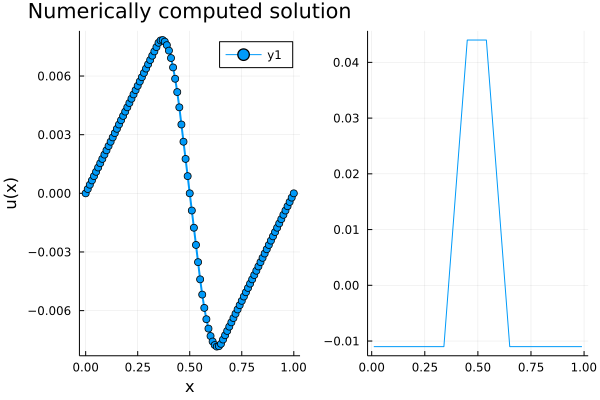

In [16]:
 #..construct the 1D mesh
N = 100; Np1 = N+1; h = 1/N; h2=h*h; 
x = Vector(0:h:1); 
xmid = x[1:end-1].+h/2; 

#..construct the source function 
xleft  = .4; fleft  = ((x.>=0.35).*(x.<=0.45));
xright = .6; fright = -((x.>=0.55).*(x.<=0.65)); 

#..use superposition to compute total f 
f = fleft+fright; 

#..construct the coefficient matrix with our the boundary conditions 
e = ones(Np1); #..note that ones(N+1,1) does *not* work here 
A = Tridiagonal(-e[2:end], 2*e, -e[2:end]); 
A = (1/h2)*A; 

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,1] = 1;          A[1,2] = 0;          f[1] = 0; 
A[end,end-1]=0;      A[end,end] = 1;      f[end] = 0;  

#..construct the matrix enabling the post-processing 
#..beware of B and BT being rectangular 
B = Bidiagonal(e/2, -e[2:end]/2, :U) 
B = (1/h)*B
BT = Transpose(B)

#..solve the linear system
u = A \ f; 

#..compute ux
ux = B*u; 
uxx = BT*ux; 

#..plot the solution  
p1=plot(x,u,shape=:circle,lw=2)
xlabel!("x") 
ylabel!("u(x)")
title!("Numerically computed solution")

p2 = plot(x[2:end-1], ux[2:end-1], legend=false) 

p3 = plot(x[2:end-1], uxx[2:end-1], legend=false)

plot(p1,p2)


### Second Study: Coil and Yoke in Air 

As above, taking the magnetic reluctivity into account. 

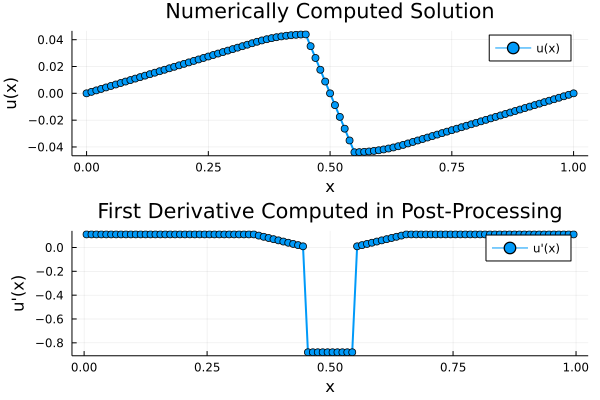

In [98]:
#..construct the 1D mesh
N = 100; Np1 = N+1; h = 1/N; h2=h*h; 
x = Vector(0:h:1); 
xmid = x[1:end-1].+h/2; 

#..construct the source function 
xleft  = .4; fleft  = ((x.>=0.35).*(x.<=0.45));
xright = .6; fright = -((x.>=0.55).*(x.<=0.65)); 
f = fleft+fright; 

#..construct the diffusion coefficient 
D = 1 .+ (0.0001-1)*((xmid.>=0.45).*(xmid.<=0.55));

#..construct the matrix enabling the computation of ux and uxx 
#..we use comprehension to construct the rectangular matrix B 
B = Float64[i==j ? (-1.)/h : i==j-1 ? 1/h : 0 for i = 1:N, j=1:Np1]
BT = Transpose(B)
A = BT*Diagonal(D)*B; 

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,1] = 1.;          A[1,2] = 0.;          f[1] = 0.; 
A[end,end-1]=0;      A[end,end] = 1.;      f[end] = 0.;  

#..solve the linear system
u = A \ f; 

#..compute ux
ux = B*u; 
uxx = BT*ux; 

#..plot the solution  
p1=plot(x,u,shape=:circle,lw=2, label="u(x)")
xlabel!("x") 
ylabel!("u(x)")
title!("Numerically Computed Solution")

#..plot the first derivative ux of the computed solution  
p2 = plot(xmid, ux, shape=:circle, lw=2, label="u'(x)")
xlabel!("x") 
ylabel!("u'(x)")
title!("First Derivative Computed in Post-Processing")

plot(p1,p2,layout=(2,1))

As above, taking again the magnetic reluctivity into account. 

### Third Study: Coil and Yoke with Airgap 

In [ ]:
#..construct the 1D mesh
N = 100; Np1 = N+1; h = 1/N; h2=h*h; 
x = Vector(0:h:1); 
xmid = x[1:end-1].+h/2; 

#..construct the source function 
xleft  = .4; fleft  = ((x.>=0.35).*(x.<=0.45));
xright = .6; fright = -((x.>=0.55).*(x.<=0.65)); 
f = fleft+fright; 

#..construct the diffusion coefficient 
D = 1 .+ (0.0001-1)*((xmid.>=0.45).*(xmid.<=0.475)).+ (0.0001-1)*((xmid.>=0.525).*(xmid.<=0.55));

#..construct the matrix enabling the computation of ux and uxx 
#..we use comprehension to construct the rectangular matrix B 
B = Float64[i==j ? (-1.)/h : i==j-1 ? 1/h : 0 for i = 1:N, j=1:Np1]
BT = Transpose(B)
A = BT*Diagonal(D)*B; 

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,1] = 1.;          A[1,2] = 0.;          f[1] = 0.; 
A[end,end-1]=0;      A[end,end] = 1.;      f[end] = 0.;  

#..solve the linear system
u = A \ f; 

#..compute ux
ux = B*u; 
uxx = BT*ux; 

#..plot the solution  
p1=plot(x,u,shape=:circle,lw=2, label="u(x)")
xlabel!("x") 
ylabel!("u(x)")
title!("Numerically Computed Solution")

#..plot the first derivative ux of the computed solution  
p2 = plot(xmid, ux, shape=:circle, lw=2, label="u'(x)")
xlabel!("x") 
ylabel!("u'(x)")
title!("First Derivative Computed in Post-Processing")

plot(p1,p2,layout=(2,1))

## Section 5/6: A Closer Look into Julia

Julia employs the concept of multiple dispatch. This means that Julia checks the type of the input variable and chooses the method most specific to that type of variable. In the following, we illustrate this idea for the linear system solve using the backslash operator. The example shows that Julia implements more than hundred methods to perform backslash. 

In [12]:
A = [1. 2. 3.; 4. 5. 6.; 7. 8. 9.]
b = [1.; 2.; 3]
typeof(A)
methods(\)

# 144 methods for generic function "\":
[1] \(A::Union{QR{T, S} where S<:AbstractMatrix{T}, LinearAlgebra.QRCompactWY{T, M} where M<:AbstractMatrix{T}, QRPivoted{T, S} where S<:AbstractMatrix{T}}, BIn::Union{Array{Complex{T}, 1}, Array{Complex{T}, 2}}) where T<:Union{Float32, Float64} in LinearAlgebra at /Applications/Julia-1.6.app/Contents/Resources/julia/share/julia/stdlib/v1.6/LinearAlgebra/src/qr.jl:961
[2] \(A::Union{QR, LinearAlgebra.QRCompactWY, QRPivoted}, B::Diagonal) in LinearAlgebra at /Applications/Julia-1.6.app/Contents/Resources/julia/share/julia/stdlib/v1.6/LinearAlgebra/src/diagonal.jl:499
[3] \(A::Union{QR{TA, S} where S<:AbstractMatrix{TA}, LinearAlgebra.QRCompactWY{TA, M} where M<:AbstractMatrix{TA}, QRPivoted{TA, S} where S<:AbstractMatrix{TA}}, B::AbstractVecOrMat{TB}) where {TA, TB} in LinearAlgebra at /Applications/Julia-1.6.app/Contents/Resources/julia/share/julia/stdlib/v1.6/LinearAlgebra/src/qr.jl:940
[4] \(L::Union{Adjoint{T, var"#s832"} where var"#s832"<:(UpperTriangular{T, var"#s831"} where var"#s831"<:(Union{SparseArrays.AbstractSparseMatrixCSC{T, Ti}, SubArray{T, 2, var"#s832", Tuple{Base.Slice{Base.OneTo{Int64}}, I}, L} where {I<:AbstractUnitRange, var"#s832"<:SparseArrays.AbstractSparseMatrixCSC{T, Ti}, L}} where Ti)), Adjoint{T, var"#s830"} where var"#s830"<:(UnitUpperTriangular{T, var"#s829"} where var"#s829"<:(Union{SparseArrays.AbstractSparseMatrixCSC{T, Ti}, SubArray{T, 2, var"#s832", Tuple{Base.Slice{Base.OneTo{Int64}}, I}, L} where {I<:AbstractUnitRange, var"#s832"<:SparseArrays.AbstractSparseMatrixCSC{T, Ti}, L}} where Ti)), Adjoint{T, var"#s832"} where var"#s832"<:(LowerTriangular{T, var"#s831"} where var"#s831"<:(Union{SparseArrays.AbstractSparseMatrixCSC{T, Ti}, SubArray{T, 2, var"#s832", Tuple{Base.Slice{Base.OneTo{Int64}}, I}, L} where {I<:AbstractUnitRange, var"#s832"<:SparseArrays.AbstractSparseMatrixCSC{T, Ti}, L}} where Ti)), Adjoint{T, var"#s830"} where var"#s830"<:(UnitLowerTriangular{T, var"#s829"} where var"#s829"<:(Union{SparseArrays.AbstractSparseMatrixCSC{T, Ti}, SubArray{T, 2, var"#s832", Tuple{Base.Slice{Base.OneTo{Int64}}, I}, L} where {I<:AbstractUnitRange, var"#s832"<:SparseArrays.AbstractSparseMatrixCSC{T, Ti}, L}} where Ti)), LowerTriangular{T, var"#s832"} where var"#s832"<:(Union{SparseArrays.AbstractSparseMatrixCSC{T, Ti}, SubArray{T, 2, var"#s832", Tuple{Base.Slice{Base.OneTo{Int64}}, I}, L} where {I<:AbstractUnitRange, var"#s832"<:SparseArrays.AbstractSparseMatrixCSC{T, Ti}, L}} where Ti), Transpose{T, var"#s828"} where var"#s828"<:(UpperTriangular{T, var"#s827"} where var"#s827"<:(Union{SparseArrays.AbstractSparseMatrixCSC{T, Ti}, SubArray{T, 2, var"#s832", Tuple{Base.Slice{Base.OneTo{Int64}}, I}, L} where {I<:AbstractUnitRange, var"#s832"<:SparseArrays.AbstractSparseMatrixCSC{T, Ti}, L}} where Ti)), Transpose{T, var"#s828"} where var"#s828"<:(LowerTriangular{T, var"#s827"} where var"#s827"<:(Union{SparseArrays.AbstractSparseMatrixCSC{T, Ti}, SubArray{T, 2, var"#s832", Tuple{Base.Slice{Base.OneTo{Int64}}, I}, L} where {I<:AbstractUnitRange, var"#s832"<:SparseArrays.AbstractSparseMatrixCSC{T, Ti}, L}} where Ti)), Transpose{T, var"#s826"} where var"#s826"<:(UnitLowerTriangular{T, var"#s825"} where var"#s825"<:(Union{SparseArrays.AbstractSparseMatrixCSC{T, Ti}, SubArray{T, 2, var"#s832", Tuple{Base.Slice{Base.OneTo{Int64}}, I}, L} where {I<:AbstractUnitRange, var"#s832"<:SparseArrays.AbstractSparseMatrixCSC{T, Ti}, L}} where Ti)), Transpose{T, var"#s826"} where var"#s826"<:(UnitUpperTriangular{T, var"#s825"} where var"#s825"<:(Union{SparseArrays.AbstractSparseMatrixCSC{T, Ti}, SubArray{T, 2, var"#s832", Tuple{Base.Slice{Base.OneTo{Int64}}, I}, L} where {I<:AbstractUnitRange, var"#s832"<:SparseArrays.AbstractSparseMatrixCSC{T, Ti}, L}} where Ti)), UnitLowerTriangular{T, var"#s831"} where var"#s831"<:(Union{SparseArrays.AbstractSparseMatrixCSC{T, Ti}, SubArray{T, 2, var"#s832", Tuple{Base.Slice{Base.OneTo{Int64}}, I}, L} where {I<:AbstractUnitRange, var"#s832"<:Sp

## Section 6/6: References

1. Solving PDEs in Julia by Chris Rackauckas [https://nextjournal.com/sosiris-de/pde-2018]. Especially Part I is relevant here. 
2. Finite Difference Method [https://pythonnumericalmethods.berkeley.edu/notebooks/chapter23.03-Finite-Difference-Method.html]. 